# 10.04 Artificial Neural Networks

If we place several perceptrons (neurons) together
we can slice the search space with several lines.
This is called an *Artificial Neural Network*
(ANN, or just Neural Network, NN, for short).
It is not trivial to train these neurons,
after all we do not know what the output of most neurons should be.

For a first let's just use `sklearn`'s `MLPClassifier` (multi-layer-perceptron-classifier)
as a model and see if we can make it work.
We take all model evaluation common suspects.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier

![Lieutenant Columbo](ol-columbo.svg)

<div style="text-align:right;"><sup>ol-columbo.svg</sup></div>

## Glass Dataset

The forensics of glass composition can reveal the provenience of a piece of glass,
yet different brands of glass are slightly different from each other.
We will build a model which will classify glass based on its composition,
and will use online learning so that we are ready to learn from new data at any time.
If anyone asks us to be police detectives someday we now have a head start.

This is a dataset at UCI machine learning repository, we need to build our `load_glass` function.
The classes are numbered from $1$ in the dataset, and class $3$ is missing,
we fix both issues during the data load.

In [2]:
import os
import sys

import requests
from sklearn import datasets
from sklearn.utils import Bunch


def load_glass() -> Bunch:
    glass_dir = "uci_glass"
    data_dir = datasets.get_data_home()
    data_path = os.path.join(data_dir, glass_dir, "glass.data")
    descr_path = os.path.join(data_dir, glass_dir, "glass.names")
    glass_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
    glass_descr = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.names"
    os.makedirs(os.path.join(data_dir, glass_dir), exist_ok=True)
    try:
        with open(descr_path, "r") as f:
            descr = f.read()
    except IOError:
        print("Downloading file from", glass_descr, file=sys.stderr)
        r = requests.get(glass_descr)
        with open(descr_path, "w") as f:
            f.write(r.text)
        descr = r.text
        r.close()
    try:
        data = pd.read_csv(data_path, delimiter=",", header=None).to_numpy()
    except IOError:
        print("Downloading file from", glass_data, file=sys.stderr)
        r = requests.get(glass_data)
        with open(data_path, "w") as f:
            f.write(r.text)
        r.close()
        data = pd.read_csv(data_path, delimiter=",", header=None).to_numpy()
    target = data[:, 10].astype(np.int64).copy()
    target[target > 3] -= 1  # fix non-existent classes
    target -= 1  # fix class numbering
    return Bunch(
        DESCR=descr,
        data=data[:, :10].copy(),
        feature_names=[
            "ID",
            "RI",
            "Na",
            "Mg",
            "Al",
            "Si",
            "K",
            "Ca",
            "Ba",
            "Fe",
        ],
        target=target,
        target_names=[
            "windows_float_processed",
            "windows_non_float_processed",
            "vehicle_windows",
            "containers",
            "tableware",
            "headlamps",
        ],
    )


glass = load_glass()
print(glass.DESCR)

1. Title: Glass Identification Database

2. Sources:
    (a) Creator: B. German
        -- Central Research Establishment
           Home Office Forensic Science Service
           Aldermaston, Reading, Berkshire RG7 4PN
    (b) Donor: Vina Spiehler, Ph.D., DABFT
               Diagnostic Products Corporation
               (213) 776-0180 (ext 3014)
    (c) Date: September, 1987

3. Past Usage:
    -- Rule Induction in Forensic Science
       -- Ian W. Evett and Ernest J. Spiehler
       -- Central Research Establishment
          Home Office Forensic Science Service
          Aldermaston, Reading, Berkshire RG7 4PN
       -- Unknown technical note number (sorry, not listed here)
       -- General Results: nearest neighbor held its own with respect to the
             rule-based system

4. Relevant Information:n
      Vina conducted a comparison test of her rule-based system, BEAGLE, the
      nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is 
      a product available 

---

The support of the classes is quite different.
This isn't an easy problem to model.

In [3]:
pd.Series(glass.target).value_counts()

1    76
0    70
5    29
2    17
3    13
4     9
Name: count, dtype: int64

Without knowing much about this model,
let's try to use a neural network to classify this dataset.
We know that the neural network is a good amount
of interconnected perceptrons and that we perturb the perceptron weights
based on errors in classification to achieve convergence.

This is a real dataset,
we may as well try to do things properly and take a test set out.
This may prove a tad difficult due to the big differences in support.
One could we may do is to select a good subset of classes and split train and test sets from these.
But we will attempt to use the full dataset,
we pass `stratify=` to `train_test_split` which will this way attempt
to maintain class support the same across the training and test sets.

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(
    glass.data,
    glass.target,
    test_size=0.2,
    stratify=glass.target,
)

We also know that `sklearn` provides us with a simple neural network class,
no harm in trying it out.

By now we can guess what `max_iter`, `alpha=` and `tol=` arguments are.
The `solver=sgd` is stochastic gradient descent, where the default
is an optimizer with many other heuristics called `adam`.
The `hidden_layer_sizes=(20,)` means that we have a neural network
of $10$ input perceptrons/neurons in a layer, the number of features in or dataset;
$20$ perceptrons/neurons in a hidden layer that do the bulk of the processing;
and $6$ perceptrons/neurons in an output layer, one for each class.
The `activetion=` is the activation function of the perceptrons to which we will return.

In [5]:
net = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(20,),
    alpha=0.01,
    tol=0.001,
    max_iter=500,
    solver="sgd",
)
param_dict = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "tol": [0.001, 0.01, 0.1],
}
grid = GridSearchCV(net, param_dict, cv=5)
grid.fit(xtrain, ytrain)
grid.best_estimator_, grid.best_score_

(MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, solver='sgd', tol=0.001),
 np.float64(0.9242016806722688))

Some models may not converge but the cross-validation should root them out.
And the best model should be a converged network.

The score isn't bad but a classification report may give a better view
of how a multilabel classifier performs.

In [6]:
y_hat = grid.best_estimator_.predict(xtest)
print(
    classification_report(
        ytest,
        y_hat,
        target_names=glass.target_names,
        zero_division=0,
    )
)

                             precision    recall  f1-score   support

    windows_float_processed       1.00      0.93      0.96        14
windows_non_float_processed       0.88      1.00      0.94        15
            vehicle_windows       0.50      0.67      0.57         3
                 containers       0.33      0.33      0.33         3
                  tableware       0.00      0.00      0.00         2
                  headlamps       1.00      1.00      1.00         6

                   accuracy                           0.86        43
                  macro avg       0.62      0.65      0.63        43
               weighted avg       0.83      0.86      0.84        43



When the support is low, we may have cases with zero precision or recall,
which in turn will make a zero `F1` score due to a division by zero.
That is the reason we added `zero_division=0` above to prevent zero division warnings.

And a confusion matrix may give further information.

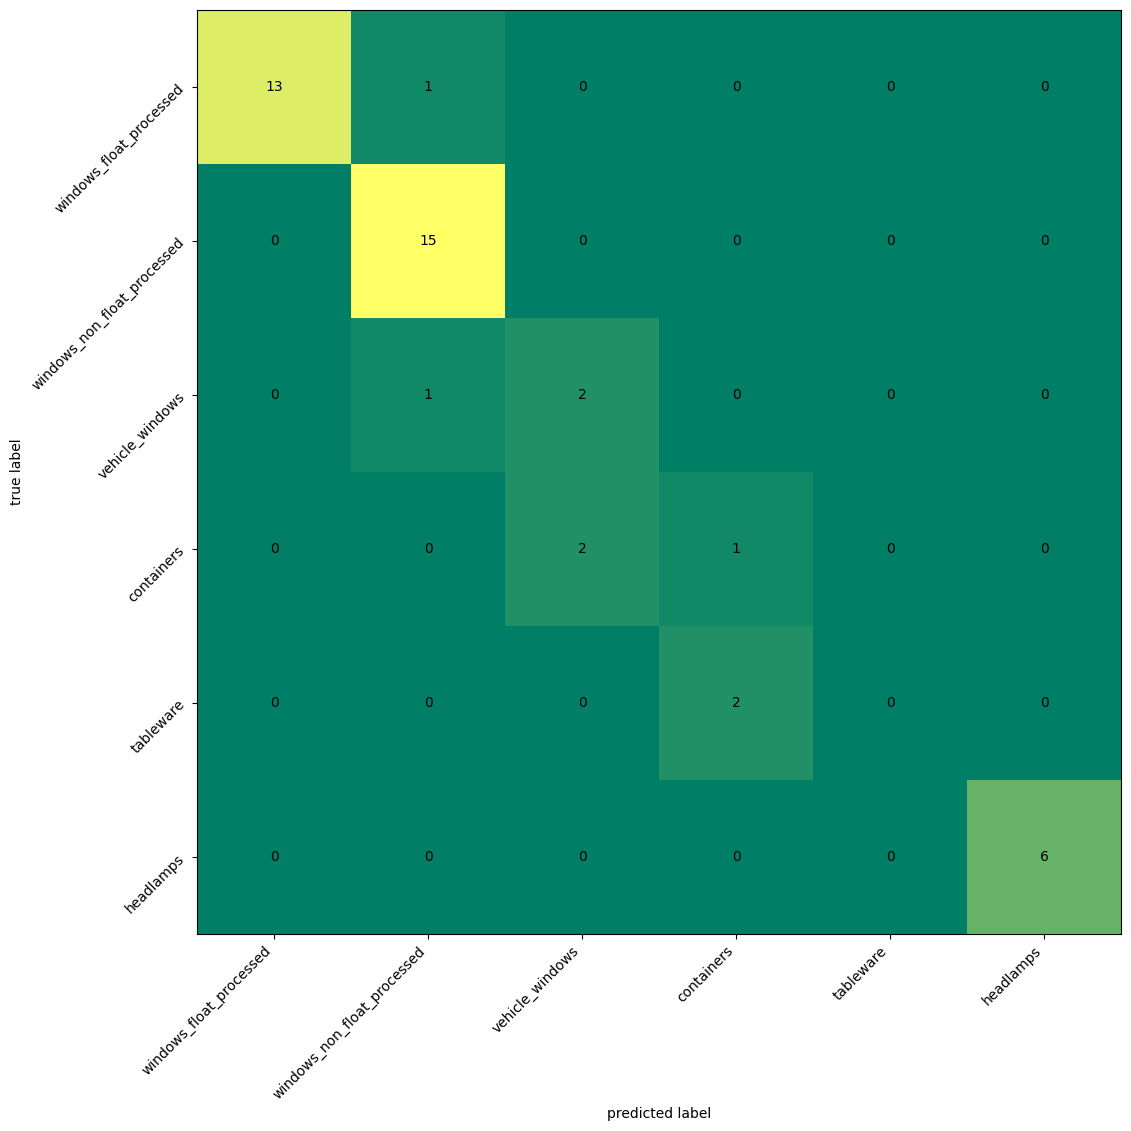

In [7]:
mat = confusion_matrix(ytest, y_hat)
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(mat, cmap="summer")
ticks = np.arange(0, len(glass.target_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(glass.target_names, rotation=45, ha="right")
ax.set_yticklabels(glass.target_names, rotation=45, ha="right")
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")
ax.xaxis.set_ticks_position("bottom")

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, mat[i, j], ha="center", va="center")

From the above we learned one of the most important details about neural networks:
since weights are updated based on classification errors between expected and predicted
classes, if we have classes with very little support the network will often fail at classifying them.

As we get collect more data the effect of classes with smaller support diminishes.
Neural Nets work in similar fashion to us, humans, you cannot show a person 2 paintings
by Titian and then 200 painting not by Titian and expect her to be an expert at identifying Titian's work.
ANNs work best the more data you have and the more diverse the data is.

For the glass data we'll leave as an exercise trying out a Random Forest,
that model is very good at digging out classes with small support
(contrary to decision trees!).
But for now let's understand more about ANNs.

## References

[UCI - Glass Identification Dataset][1]

[1]: https://archive.ics.uci.edu/ml/datasets/glass+identification "UCI Glass"